In [14]:
from datasets import load_dataset
import ast
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, RobertaTokenizer, T5ForConditionalGeneration, AutoModelForCausalLM
import torch
from rouge_score import rouge_scorer
import Levenshtein
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = load_dataset("openai/openai_humaneval", split="test")


In [3]:
sub_samples = data.select(range(20))
print(sub_samples[0].keys())
print(sub_samples[6]['canonical_solution'])

dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'])
    def parse_paren_group(s):
        depth = 0
        max_depth = 0
        for c in s:
            if c == '(':
                depth += 1
                max_depth = max(depth, max_depth)
            else:
                depth -= 1

        return max_depth

    return [parse_paren_group(x) for x in paren_string.split(' ') if x]



In [4]:
original_prompt = sub_samples['prompt']
print(original_prompt[19])

from typing import List


def sort_numbers(numbers: str) -> str:
    """ Input is a space-delimited string of numberals from 'zero' to 'nine'.
    Valid choices are 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight' and 'nine'.
    Return the string with numbers sorted from smallest to largest
    >>> sort_numbers('three one five')
    'one three five'
    """



In [5]:
class ObfuscationOfPrompts(ast.NodeTransformer):

    def __init__(self, mode='low', exclude=None):
        self.mapping = {}
        self.obfuscationMode = mode
        self.flag = 0
        self.excludeList = exclude or {'List', 'typing', 'str', 'int', 'float', 'dict', 'set'}

    def _get_new_name(self, original, is_func=False):

        if original in self.excludeList or original.startswith('__'):
            return original
        
        if original not in self.mapping:
            self.flag += 1

            if self.obfuscationMode == 'low':
                prefix = f"{original[:7]}_" if is_func else "var"
                self.mapping[original] = f"{prefix}{self.flag}"
                
            else:
                self.mapping[original] = f"_0x{self.flag:03x}"
        
        return self.mapping[original]
    
    def visit_Name(self, node):
        node.id = self._get_new_name(node.id)
        return node
    
    def visit_arg(self, node):
        node.arg = self._get_new_name(node.arg)
        return node
    
    def visit_FunctionDef(self, node):

        if self.obfuscationMode == 'high':

            if (node.body and isinstance(node.body[0], ast.Expr) and 
                isinstance(node.body[0].value, (ast.Constant, ast.Str))):
                node.body.clear()
        
        node.name = self._get_new_name(node.name, is_func=True)
        self.generic_visit(node)
        return node
    
    def visit_Import(self, node): return node
    def visit_ImportFrom(self, node): return node

def obfuscate(prompt: str, mode: str = 'low') -> str:

    tree = ast.parse(prompt)
    transformer = ObfuscationOfPrompts(mode=mode)
    new_tree = transformer.visit(tree)
    return ast.unparse(new_tree)

In [6]:
print(obfuscate(original_prompt[0], mode='low'))

from typing import List

def has_clo_1(var2: List[float], var3: float) -> var4:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """


In [7]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-3B")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-3B",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto")

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


In [8]:
def getOutput(prompt: str):

    stop_tokens = ["<|endoftext|>", "<|file_separator|>", "\n\nif __name__", "\ndef main"]
    
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False, 
            repetition_penalty=1.1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    input_len = inputs["input_ids"].shape[1]
    gen_tokens = outputs[0][input_len:] 
    completion = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip()

    for stop in stop_tokens:
        if stop in completion:
            completion = completion.split(stop)[0].strip()

    return completion

In [9]:
r_score = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_utilityScore(canonical_solution, generated_solution):
    s = r_score.score(canonical_solution, generated_solution)
    return s["rougeL"].fmeasure

In [10]:
def compute_privacyScore(original, obfuscated):
    distance = Levenshtein.distance(original, obfuscated)
    return distance / max(len(original), 1)

In [11]:
results = []
for sample in sub_samples:
    original_prompt = sample['prompt']
    low_obfuscate_prompt = obfuscate(original_prompt, 'low')
    high_obfuscate_prompt = obfuscate(original_prompt, 'high')

    prompt_variants = [
    ("original", original_prompt),
    ("low_obfuscate", low_obfuscate_prompt),
    ("high_obfuscate", high_obfuscate_prompt),
]
    
    for lvl, prompt in prompt_variants:
        generated_code = getOutput(prompt)

        utility_score = compute_utilityScore(sample['canonical_solution'], generated_code)
        privacy_score = compute_privacyScore(original_prompt, prompt)

        results.append({
        "task_id": sample["task_id"],
        "obfuscation": lvl,
        "utility_score": utility_score,
        "privacy_score": privacy_score,
    })
    print(sample["task_id"])



HumanEval/0
HumanEval/1
HumanEval/2
HumanEval/3
HumanEval/4
HumanEval/5
HumanEval/6
HumanEval/7
HumanEval/8
HumanEval/9
HumanEval/10
HumanEval/11
HumanEval/12
HumanEval/13
HumanEval/14
HumanEval/15
HumanEval/16
HumanEval/17
HumanEval/18
HumanEval/19


In [12]:
dataframe = pd.DataFrame(results)
print(dataframe)

         task_id     obfuscation  utility_score  privacy_score
0    HumanEval/0        original       0.509804       0.000000
1    HumanEval/0   low_obfuscate       0.392157       0.086207
2    HumanEval/0  high_obfuscate       0.102041       0.818966
3    HumanEval/1        original       0.632911       0.000000
4    HumanEval/1   low_obfuscate       0.281081       0.049407
5    HumanEval/1  high_obfuscate       0.116279       0.897233
6    HumanEval/2        original       0.023077       0.000000
7    HumanEval/2   low_obfuscate       0.076923       0.048338
8    HumanEval/2  high_obfuscate       0.214286       0.927492
9    HumanEval/3        original       0.866667       0.000000
10   HumanEval/3   low_obfuscate       0.085246       0.040179
11   HumanEval/3  high_obfuscate       0.216216       0.892857
12   HumanEval/4        original       0.419355       0.000000
13   HumanEval/4   low_obfuscate       0.057692       0.051163
14   HumanEval/4  high_obfuscate       0.060606       0

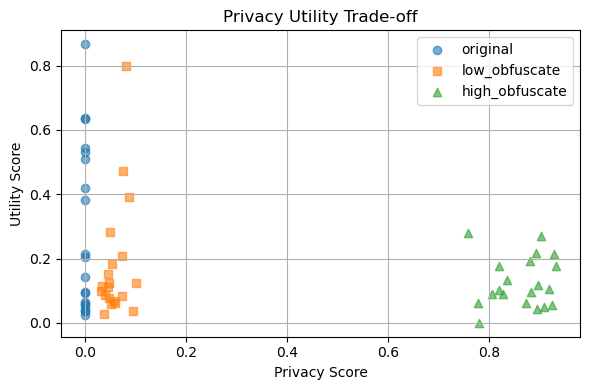

In [20]:
plt.figure(figsize=(6, 4))
for lvl, marker in [('original', 'o'), ('low_obfuscate', 's'), ('high_obfuscate', '^')]:

    s = dataframe[dataframe['obfuscation'] == lvl]
    plt.scatter(
        s['privacy_score'],
        s['utility_score'],
        label = lvl,
        marker = marker,
        alpha = 0.6
    )

plt.xlabel("Privacy Score")
plt.ylabel("Utility Score")
plt.title("Privacy Utility Trade-off")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#DISCLAIMER

**I tried "Salesforce/codet5-small" to generate code but the scores are way to much low and the graph was not looking nice. Moreover the model was halucinating and giving weird outputs even with original prompt. So i changed the model to Qwen/Qwen2.5-Coder-3B.**


##Observation

The results show a clear privacy–utility trade-off. As you can see for "original" prompt the privacy score is 0 and utility score reaches to 0.8 which makes sense because we are not masking the prompt as a result the model has full context in order to complete the code snippet. On the other hand for low obfuscate prompts, the privacy score is kind of better than the last one but utility is a bit less as we are partially masking the prompts and keeping the doc string intact so the model gets sufficient context. Lastly for high obfuscate prompts it shows a very strong privacy score. while the utility iis below 0.2.
In conclusion if we increase the privacy then the utility (correctness) decreases while increasing utility, privacy decreases.